# Streaming game influence - Data Merge & Machine Learning

En este notebook vamos a utilizar los datos procesados de los notebooks anteriores que hemos exportado a csv. Se van a analizar los datos, decidir qué variables son las más adecuadas para utilizar en los modelos y una comparativa de diferents algoritmos de machine learning

Añadimos las librerías que vamos a utilizar en el notebook

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split # data split

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.neighbors import KNeighborsRegressor #KNNeighbors regressor
from sklearn.model_selection import GridSearchCV # To calculate best knnregressor
from sklearn.tree import DecisionTreeRegressor #Decision tree regressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score # evaluation metrics
from sklearn.metrics import r2_score as r2 # evaluation metric
from math import sqrt # to calculate rmse

import joblib 
import warnings
warnings.filterwarnings('ignore') #Evitamos que salgan algunos warnings

Leemos los dataset generados en anteriores notebooks

In [3]:
# Leemos los dataset generados anteriormente
df_twitch_data = pd.read_csv('Twitch data processed.csv') #datos totales y procesados de Twitch
df_steam_data = pd.read_csv('Steam data processed.csv') #datos totales y procesados de Steam
df_twitch_data_2020 = pd.read_csv('Twitch data games post covid.csv') #Datos a partir del covid-19 de Twitch
df_steam_data_2020 = pd.read_csv('Steam data games post covid.csv') #Datos a parti del covid-19 de Steam

# Datos totales

## Data merge

A la hora de juntar los datasets vamos a renombrar las columnas de los diferentes datasets para que coincidan

In [4]:
# Cambiamos los nombres de las columnas para que sea más fácil mergear los datasets
df_steam_data.rename(columns={'gamename':'Game','avg':'Avg_players','gain':'Gain_players', 'peak':'Peak_players', 'avg_peak_perc':'avg_peak_perc_players',}, inplace=True)
df_steam_data.head()

,Game,year,month,Avg_players,Gain_players,Peak_players,avg_peak_perc_players,date
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%,2021-02-01
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%,2021-01-01
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%,2020-12-01
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%,2020-11-01
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%,2020-10-01


Al tener las columnas de 'Game' y 'data' preprocesadas en los dos datasets en merge no le indicamos las columnas por las que tiene que unir. Dejaremos que haga un innerjoin con las 2 columnas para obtener los datos totales. Como en el dataset de twitch también teníamos las categorías como valores no se muestran en el dataset final, nos centraremos solamente en los videojuegos.


In [5]:
df = pd.merge(df_twitch_data, df_steam_data)

In [6]:
df.sample(n=5)

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Day,date,year,month,Avg_players,Gain_players,Peak_players,avg_peak_perc_players
2699,113,MapleStory,1,2019,723101,40140 hours,6221,104,3276,973,54,18.01,1,2019-01-01,2019,January,837.63,-93.76,1296,64.6319%
276,47,Path of Exile,5,2016,1118968,38867 hours,17611,201,3185,1506,52,28.79,1,2016-05-01,2016,May,5700.75,-4918.72,11266,50.6014%
3966,82,Brawlhalla,7,2020,2047527,106026 hours,41874,300,18732,2755,142,19.31,1,2020-07-01,2020,July,16276.09,876.69,29804,54.6104%
578,160,Grand Theft Auto: San Andreas,9,2016,127259,8269 hours,3364,38,2023,176,11,15.39,1,2016-09-01,2016,September,685.76,-56.89,1990,34.4603%
3032,53,Rust,6,2019,2062296,120575 hours,16006,369,14463,2868,167,17.10,1,2019-06-01,2019,June,45132.57,9351.90,81658,55.2702%


Comprobamos que los datos se hayan unido bien por fechas con pd.sample

In [7]:
df[['Month', 'Year','month', 'year', 'date', 'Game']].sample(n=10)

,Month,Year,month,year,date,Game
2757,2,2019,February,2019,2019-02-01,ASTRONEER
2040,4,2018,April,2018,2018-04-01,Garry's Mod
3720,3,2020,March,2020,2020-03-01,Call of Duty: Black Ops III
3538,1,2020,January,2020,2020-01-01,Hunt: Showdown
4077,9,2020,September,2020,2020-09-01,Dota 2
2244,7,2018,July,2018,2018-07-01,The Crew 2
2238,7,2018,July,2018,2018-07-01,The Forest
4090,9,2020,September,2020,2020-09-01,SMITE
4376,1,2021,January,2021,2021-01-01,VRChat
374,6,2016,June,2016,2016-06-01,Tabletop Simulator


Vemos que las fechas coinciden con la columna date

Vemos el tamaño que nos ha quedado en el nuevo dataset

In [8]:
df.shape

(4493, 20)

Comprobamos el número de videojuegos distintos que hemos podido juntar de los 2 datsets

In [9]:
vg = df['Game'].nunique()
print("Después de la unión de datos entre Steam y Twitch hemos conseguido unir {} videojuegos ".format(vg))

Después de la unión de datos entre Steam y Twitch hemos conseguido unir 428 videojuegos 


Comprobamos los tipos de columnas qué tenemos y decidimos que hacer con ellas

In [10]:
df.dtypes

Rank                       int64
Game                      object
Month                      int64
Year                       int64
Hours_watched              int64
Hours_Streamed            object
Peak_viewers               int64
Peak_channels              int64
Streamers                  int64
Avg_viewers                int64
Avg_channels               int64
Avg_viewer_ratio         float64
Day                        int64
date                      object
year                       int64
month                     object
Avg_players              float64
Gain_players             float64
Peak_players               int64
avg_peak_perc_players     object
dtype: object

Vemos algunas columnas que tenemos que modificar:
* La columna de Hours_streamed es de tipo object al tener texto. Vamos a limpiar el texto para poder cambiar el tipo
* La columna date es de tipo objetc. Vamos a transformarla en datetime

In [11]:
# reemplazamos el texto por nada
df['Hours_Streamed'] = df['Hours_Streamed'].str.replace(' hours','')

In [12]:
#Cambiamos el tipo object a str primero y luego a int
df['Hours_Streamed'] = df['Hours_Streamed'].astype(str).astype(int)

In [13]:
# Transformación de la columna date
df['date'] = pd.to_datetime(
                          df['date'],
                          format='%Y-%m-%d'
                            )

In [14]:
#Comprobamos como han quedado la transformación de las columnas
df.dtypes

Rank                              int64
Game                             object
Month                             int64
Year                              int64
Hours_watched                     int64
Hours_Streamed                    int64
Peak_viewers                      int64
Peak_channels                     int64
Streamers                         int64
Avg_viewers                       int64
Avg_channels                      int64
Avg_viewer_ratio                float64
Day                               int64
date                     datetime64[ns]
year                              int64
month                            object
Avg_players                     float64
Gain_players                    float64
Peak_players                      int64
avg_peak_perc_players            object
dtype: object

Aligeramos el número de columnas y eliminamos algunas repetidas que no van a ser necesarias para nuestro analísis

In [15]:
# Dropping irrelevant columns
df = df.drop(['Month','month', 'year', 'Day'], axis=1)
df.head(5)

,Rank,Game,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,date,Avg_players,Gain_players,Peak_players,avg_peak_perc_players
0,2,Counter-Strike: Global Offensive,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,2016-01-01,365371.09,-12076.02,667432,54.7428%
1,3,Dota 2,2016,45185893,433397,315083,1100,44074,60815,583,104.26,2016-01-01,612174.78,38830.53,1067949,57.3225%
2,5,Call of Duty: Black Ops III,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,2016-01-01,14292.49,-3074.66,30760,46.4645%
3,16,Tom Clancy's Rainbow Six Siege,2016,4866039,242134,25742,694,42244,6549,325,20.10,2016-01-01,10244.29,2302.84,20006,51.2061%
4,19,Grand Theft Auto V,2016,4014296,407172,32724,1197,85441,5402,548,9.86,2016-01-01,46993.33,3118.61,93726,50.1391%


Comprobamos si existe algún valor nulo

In [16]:
df.isnull().sum()

Rank                     0
Game                     0
Year                     0
Hours_watched            0
Hours_Streamed           0
Peak_viewers             0
Peak_channels            0
Streamers                0
Avg_viewers              0
Avg_channels             0
Avg_viewer_ratio         0
date                     0
Avg_players              0
Gain_players             0
Peak_players             0
avg_peak_perc_players    0
dtype: int64

## Variable correlation

En este apartado vamos a analizar la correlación de variables y decidir cuáles son las más decisivas a la hora de usar en nuestros modelos de machine learning

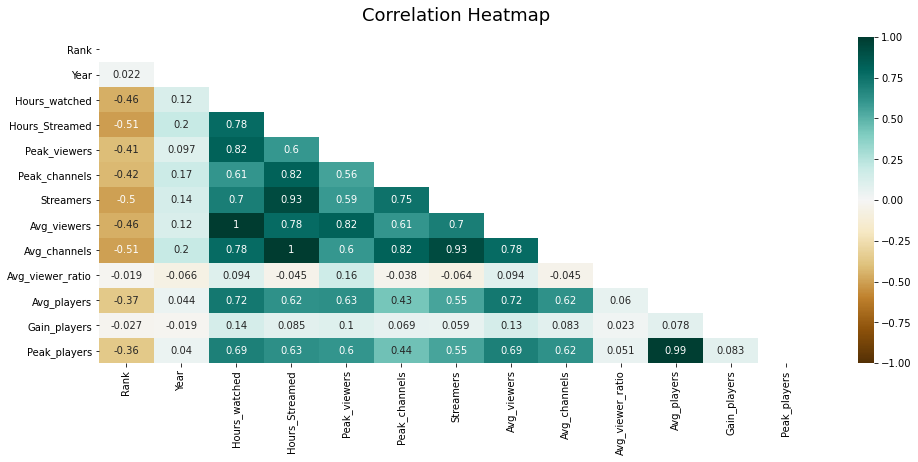

In [17]:
#Creamos una figura
plt.figure(figsize=(16, 6))
# Definimos el triángulo inferior con un correlation plot
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Tras analizar nuestra matriz de correlación vemos como hay algunas variables entre los datasets que hemos juntado que tienen cierta correlación. Esto por una parte es bueno porque nos interesa ver que los datos de diferentes plataformas están relacionados y que las cosas que afectan a una, varía en la otra. Sin embargo una correlación excesiva podría resultar un problema porque los modelos de predición no servirían. En nuestro caso nos vamos a centrar en la relación de las siguientes variables:
* Avg_players: Jugadores medios de la plataforma Steam
* Avg_viewers: Usuarios medios visualizando contenido de Steam. Elegimos esta variable y no Hours_watched porque tienen una correlación de 1. Además a la hora, por ejemplo, de usar este algoritmo para predecir la inversión publicitaria en Twitch para un determinado videojuego, los datos más relevantes por canal van a ser los visualizadores medios que los consideraríamos como usuarios únicos que han de descargar dicho juego

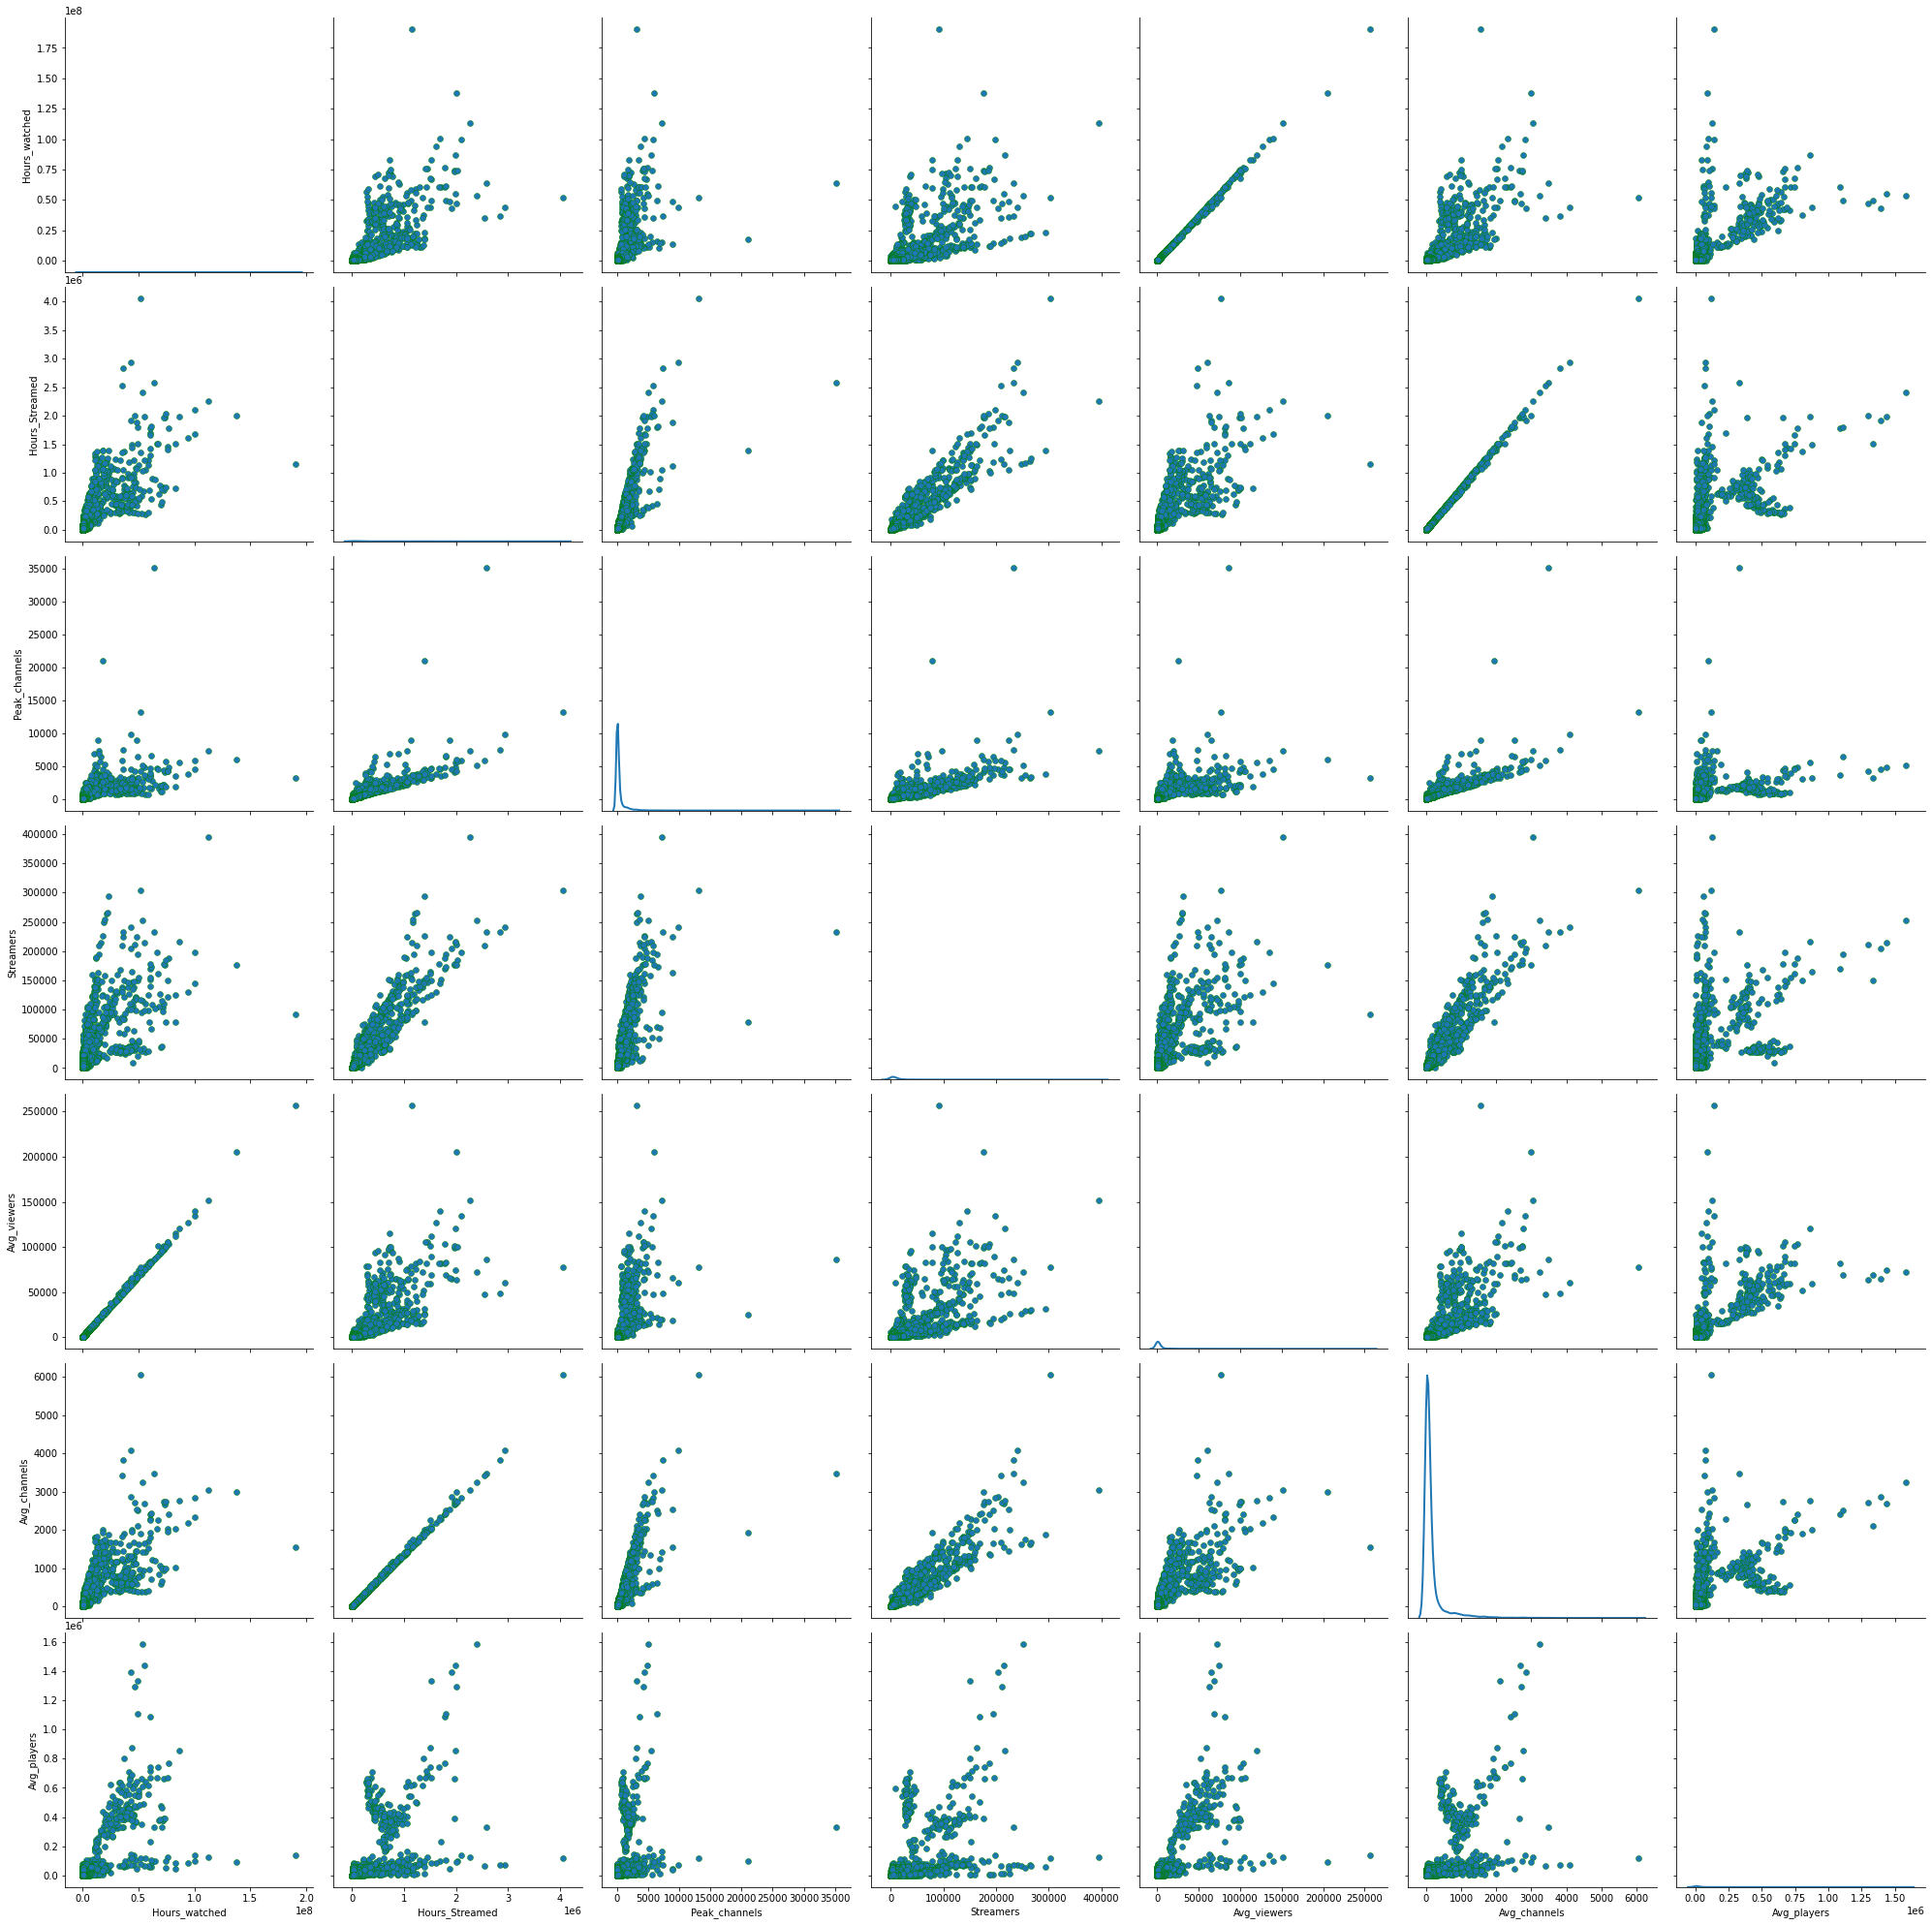

In [18]:
#Creamos un pairgrid que contendrá varios gráficos
grid = sns.PairGrid(df,
             vars = ['Hours_watched', 'Hours_Streamed', 'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_players'],
             size = 4)
grid.map_offdiag(sns.scatterplot, edgecolor="g") #Scatter plot
grid.map_diag(sns.kdeplot, lw=2, legend = False) #kdeplot en la diagonal
plt.show();

Como hemos comentado más arriba nos vamos a centar en la relación de el número de visualizadores y el número de jugadores

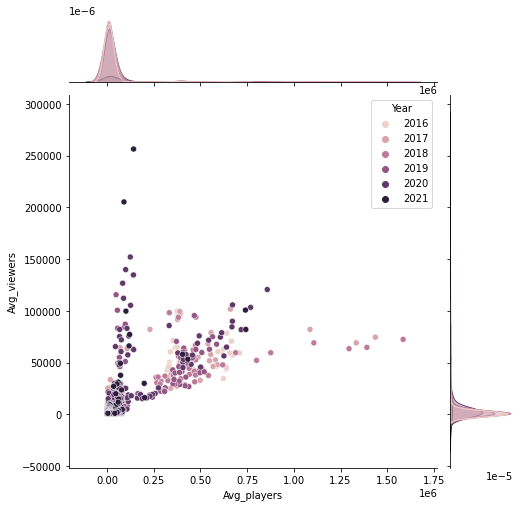

In [19]:
sns.jointplot(data=df, x="Avg_players", y="Avg_viewers", hue="Year", height= 7);

Relaciones que podemos ver en la visualización:
* Puntos oscuros pertenecientes a 2021: Se distribuyen por más verticalmente, por lo que indica que hay más usuarios viendo jugar que jugando actualmente
* Resto de puntos 2016-2020: A parte del conglomerado en los ejes, los puntos se distribuyen más diagonalmente, lo que indica que hay un equilibrio entre visualizadores de contenido y jugadores de esos mismos juegos

## Machine Learning models & Evaluation


### Datos totales

En este apartado vamos a probar diferentes modelos de machine learning para predecir el número de jugadores en función del número de visualizadores. Como hemos comentado hemos elegido estas métricas porque:
* Nº medio de visualizadores: Es un dato que lo proporciona Twitch y es fácil de comparar entre Streams. Facilita la elección de los candidatos a promocionar un producto por ejemplo. Es una métrica que va asociada a usuarios únicos al igual que el número de jugadores.
* Nº de jugadores: Son los usuarios que van a consumir nuestro producto. Al ser una métrica única por jugador fácilita el análisis

In [20]:
# Test train split for supervised training
X_var = df['Avg_viewers'].values.reshape(-1,1)
y_var = df['Avg_players'].values

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.2, random_state = 0)

Creamos una función para comparar los modelos con las métricas de error

In [21]:
def evaluate(X_test, y_test, y_hat):
    plt.scatter(X_test, y_test, color='blue', alpha=.7)
    plt.scatter(X_test, y_hat, color='orange', alpha=.8)

    mse = mean_squared_error(y_test, y_hat)
    rmsee = sqrt(mean_squared_error(y_test,y_hat)) #calculate rmse
    mae = mean_absolute_error(y_test, y_hat)
    mape = np.mean(np.abs(y_test - y_hat) / y_test)
    ev = explained_variance_score(y_test, y_hat)
    r2score = r2(y_test, y_hat)

    return print( " El MSE es: {}\n".format(mse), "El MAE es: {}\n".format(mae), "El Mape es: {}\n".format(mape), "El EV es: {}\n".format(ev), "El R2 score es: {}\n".format(r2score), "El RMSE score es: {}\n".format(rmsee))

# Lo evaluaremos con evaluate(X_test, y_test, y_hat)

Ahora comparamos los modelos. Se han elegido estos porque son losmás comunes y los que más eficacia demostrada tienen

In [22]:
# MODELING

# 1. OLS

ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

# 2. Bayesian

bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# 3. ElasticNet

en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

# 4. KNNRegressor k=3

knn3 = KNeighborsRegressor(3)
knn3.fit(X_train, y_train)
knn3_yhat = knn3.predict(X_test)

# 5. KNNRegressor k=7

knn7 = KNeighborsRegressor(7)
knn7.fit(X_train, y_train)
knn7_yhat = knn7.predict(X_test)

# 6. DecisionTreeregressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
tree_yhat = tree.predict(X_test)

Evaluamos el modelo OLS

 El MSE es: 3296501534.4556384
 El MAE es: 21098.911003483954
 El Mape es: 44.60557259125694
 El EV es: 0.6063895692142045
 El R2 score es: 0.6061884985576829
 El RMSE score es: 57415.1681566434



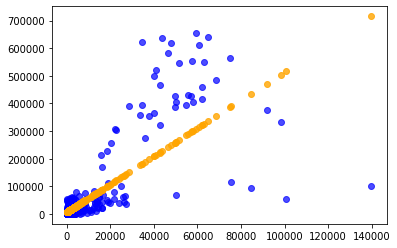

In [23]:
evaluate(X_test, y_test, ols_yhat)

Evaluamos el modelo Bayesian

 El MSE es: 3296765976.207574
 El MAE es: 21101.571945680982
 El Mape es: 44.64351241128793
 El EV es: 0.606357896768702
 El R2 score es: 0.6061569074292441
 El RMSE score es: 57417.471001495476



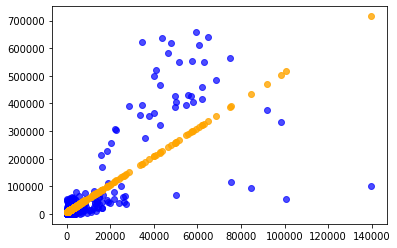

In [24]:
evaluate(X_test, y_test, bayesian_yhat)

Evaluamos el modelo ElasticNET

 El MSE es: 3296501534.4836283
 El MAE es: 21098.91100376593
 El Mape es: 44.60557259527737
 El EV es: 0.6063895692108521
 El R2 score es: 0.6061884985543391
 El RMSE score es: 57415.16815688715



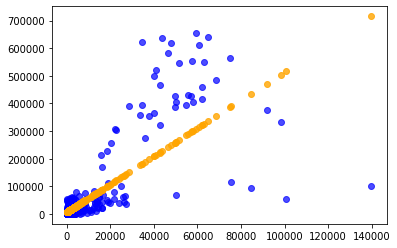

In [25]:
evaluate(X_test, y_test, en_yhat)

Evaluamos el modelo KNNRegressor con 3 vecinos

 El MSE es: 2017847024.308819
 El MAE es: 17161.481104931405
 El Mape es: 26.53131305067358
 El EV es: 0.7591008445182431
 El R2 score es: 0.7589409991112924
 El RMSE score es: 44920.45218281778



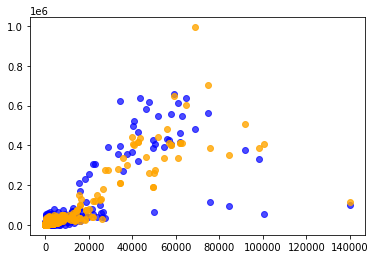

In [26]:
evaluate(X_test, y_test, knn3_yhat)

Evaluamos el modelo KNRegressor con 7 vecinos

 El MSE es: 1808588031.5749445
 El MAE es: 15996.593743842364
 El Mape es: 28.18135932662999
 El EV es: 0.7839624343142506
 El R2 score es: 0.7839398038312309
 El RMSE score es: 42527.49735847319



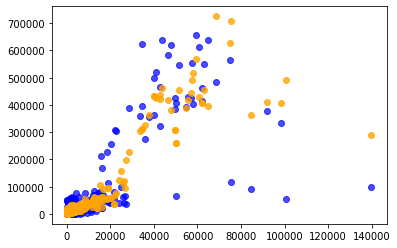

In [27]:
evaluate(X_test, y_test, knn7_yhat)

Evaluamos el modelo TreeDecisionRegressor

 El MSE es: 5286978808.951443
 El MAE es: 23448.007113251937
 El Mape es: 34.30058264069021
 El EV es: 0.3685569412494918
 El R2 score es: 0.36839918286563156
 El RMSE score es: 72711.61398945455



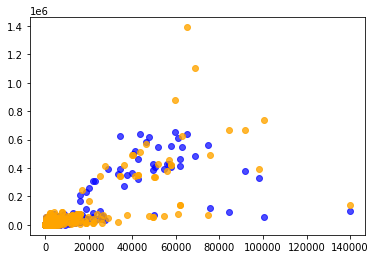

In [28]:
evaluate(X_test, y_test, tree_yhat)

Comparando los datos de los modelos nos quedaríamos con el modelo KNeighbours con k=7 vecinos ya que es el que menos error nos da. Como es el valor superior y puede tender a infinito vamos a calcular cuá es el mejor valor de kvecinos para este modelo

Vamos a calcular cuál serían los kvecinos que tengan el menor RMSE

In [29]:
value_rmse = [] #Guardar los valores de error de cada kvecino
for X in range(0, 60, 2):
    X = X+1
    model = KNeighborsRegressor(n_neighbors = X)
    model.fit(X_train, y_train)  #Model fit
    y_hat = model.predict(X_test) #make prediction on test set
    error_rmse = sqrt(mean_squared_error(y_test,y_hat)) #calculate rmse
    value_rmse.append(error_rmse) #store rmse values
    print('El RMSE para unos vecinos de k=' ,X, 'es:',error_rmse)

El RMSE para unos vecinos de k= 1 es: 72934.66631417976
El RMSE para unos vecinos de k= 3 es: 44920.45218281778
El RMSE para unos vecinos de k= 5 es: 40574.9648572495
El RMSE para unos vecinos de k= 7 es: 42527.49735847319
El RMSE para unos vecinos de k= 9 es: 42216.353731984425
El RMSE para unos vecinos de k= 11 es: 41519.53205604253
El RMSE para unos vecinos de k= 13 es: 41733.274509128794
El RMSE para unos vecinos de k= 15 es: 41838.45393259592
El RMSE para unos vecinos de k= 17 es: 41151.27195886531
El RMSE para unos vecinos de k= 19 es: 41008.95352350989
El RMSE para unos vecinos de k= 21 es: 41658.15178984622
El RMSE para unos vecinos de k= 23 es: 41680.32727697446
El RMSE para unos vecinos de k= 25 es: 41262.016348073645
El RMSE para unos vecinos de k= 27 es: 41263.594408504716
El RMSE para unos vecinos de k= 29 es: 41600.04144631807
El RMSE para unos vecinos de k= 31 es: 41490.97591261707
El RMSE para unos vecinos de k= 33 es: 41451.54355307364
El RMSE para unos vecinos de k= 3

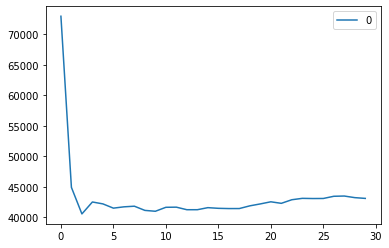

In [30]:
#Dibujamos los valores de RMSE en función de los k vecinos
curve_rmse = pd.DataFrame(value_rmse) #elbow curve 
curve_rmse.plot();

Vemos como la curva cae en los valores del 0 al 10, por lo que vamos a insertar esos valores mínimos en GridSearchCV para que nos determine cuál es el mejor valor

In [31]:
parameters = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knnreg = KNeighborsRegressor()

model = GridSearchCV(knnreg, parameters, cv=5) #Determines the cross-validation splitting strategy
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 5}

 El MSE es: 1646327773.1670318
 El MAE es: 16094.670874304784
 El Mape es: 29.51120088423631
 El EV es: 0.8033950178194871
 El R2 score es: 0.8033239768158766
 El RMSE score es: 40574.9648572495



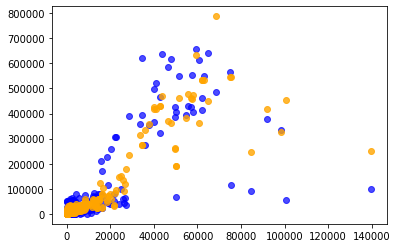

In [32]:
# KNNRegressor k=5

knn5 = KNeighborsRegressor(5)
knn5.fit(X_train, y_train)
knn5_yhat = knn5.predict(X_test)

evaluate(X_test, y_test, knn5_yhat)

Comprobamos que el mejor modelo para predecir el número de jugadores en función del número de espectadores en Twitch para un determinado juego es el KNNregresor con un parámetro k=5.

###  Exportamos nuestro modelo con Joblib

Para poder usar nuestro modelo en un front-end vamos a tener que exportarlo en formato pkl

In [33]:
model_file = open("Models/knn5_regression_total.pkl","wb")
joblib.dump(knn5,model_file)
model_file.close()

###  Exportamos nuestro nuevo dataset completo mergeado

Para poder usar con los datos completos en un front-end

In [36]:
#Exportamos los datos totales de Steam y Twitch
df.to_csv('Total data stream and games.csv', encoding='utf-8', index=False, header=True)

# Datos a partir de 2020

En este apartado crearemos un modelo de ML a partir de los datos desde el cambiod e tendencia del covid-19.

Se van a seguir los mismos paso de limpieza y unión que en el anterior apartado, por lo que algunos pasos no los comentaremos

## Data merge

In [37]:
# Cambiamos los nombres de las columnas para que sea más fácil mergear los datasets
df_steam_data_2020.rename(columns={'gamename':'Game','avg':'Avg_players','gain':'Gain_players', 'peak':'Peak_players', 'avg_peak_perc':'avg_peak_perc_players',}, inplace=True)
df_steam_data_2020.head()

,Game,year,month,Avg_players,Gain_players,Peak_players,avg_peak_perc_players,date
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%,2021-02-01
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%,2021-01-01
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%,2020-12-01
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%,2020-11-01
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%,2020-10-01


Al tener las columnas de 'Game' y 'data' preprocesadas en los dos datasets en merge no le indicamos las columnas por las que tiene que unir. Dejaremos que haga un innerjoin con las 2 columnas para obtener los datos totales. Como en el dataset de twitch también teníamos las categorías como valores no se muestran en el dataset final, nos centraremos solamente en los videojuegos.


In [38]:
df_steam_data_2020.head()

,Game,year,month,Avg_players,Gain_players,Peak_players,avg_peak_perc_players,date
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%,2021-02-01
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%,2021-01-01
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%,2020-12-01
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%,2020-11-01
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%,2020-10-01


In [39]:
df_twitch_data_2020.head()

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Day,date
0,1,Apex Legends,2,2019,123090969,5580337 hours,666868,18932,663781,183444,8316,22.06,1,2019-02-01
1,2,League of Legends,2,2019,94991296,1779043 hours,387330,4518,167824,141566,2651,53.39,1,2019-02-01
2,3,Fortnite,2,2019,84064959,7238650 hours,658887,67544,810687,125283,10787,11.61,1,2019-02-01
3,4,Just Chatting,2,2019,51698098,733647 hours,182185,2336,121349,77046,1093,70.47,1,2019-02-01
4,5,Dota 2,2,2019,50259236,528057 hours,272771,1601,43882,74901,786,95.18,1,2019-02-01


In [40]:
df_2020 = pd.merge(df_twitch_data_2020, df_steam_data_2020)

In [41]:
df_2020.sample(n=5)

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Day,date,year,month,Avg_players,Gain_players,Peak_players,avg_peak_perc_players
677,99,Call of Duty: Black Ops III,10,2020,1414716,164697 hours,64809,476,23223,1904,221,8.59,1,2020-10-01,2020,October,3415.09,591.99,6288,54.3112%
56,148,Farming Simulator 19,1,2020,551841,54062 hours,5842,414,6681,742,72,10.21,1,2020-01-01,2020,January,10879.04,55.33,22350,48.6758%
566,179,RimWorld,8,2020,600629,33839 hours,10181,91,2657,808,45,17.75,1,2020-08-01,2020,August,16529.27,1285.90,23344,70.8074%
156,20,Dead by Daylight,3,2020,11911331,596711 hours,50220,1458,55228,16031,803,19.96,1,2020-03-01,2020,March,30347.14,6925.91,51146,59.3343%
617,130,Football Manager 2020,9,2020,929656,34294 hours,13942,131,3313,1292,47,27.11,1,2020-09-01,2020,September,56234.04,-4018.58,87558,64.2249%


Comprobamos que los datos se hayan unido bien por fechas con pd.sample

In [42]:
df_2020[['Month', 'Year','month', 'year', 'date', 'Game']].sample(n=10)

,Month,Year,month,year,date,Game
554,8,2020,August,2020,2020-08-01,Gears 5
588,9,2020,September,2020,2020-09-01,Crusader Kings III
960,2,2021,February,2021,2021-02-01,The Elder Scrolls V: Skyrim
796,12,2020,December,2020,2020-12-01,DayZ
102,2,2020,February,2020,2020-02-01,Hunt: Showdown
954,2,2021,February,2021,2021-02-01,MapleStory
820,12,2020,December,2020,2020-12-01,War Thunder
778,11,2020,November,2020,2020-11-01,Resident Evil 2
453,7,2020,July,2020,2020-07-01,Hunt: Showdown
264,4,2020,April,2020,2020-04-01,Warframe


Vemos el tamaño que nos ha quedado en el nuevo dataset. Como es lógico será un número menor de elementos al ser un periodo de tiempo más corto

In [43]:
df_2020.shape

(995, 20)

Comprobamos el número de videojuegos distintos que hemos podido juntar de los 2 datsets

In [44]:
vg = df_2020['Game'].nunique()
print("Después de la unión de datos desde 2020 entre Steam y Twitch hemos conseguido unir {} videojuegos ".format(vg))

Después de la unión de datos desde 2020 entre Steam y Twitch hemos conseguido unir 178 videojuegos 


Comprobamos los tipos de columnas qué tenemos y decidimos que hacer con ellas

In [45]:
df_2020.dtypes

Rank                       int64
Game                      object
Month                      int64
Year                       int64
Hours_watched              int64
Hours_Streamed            object
Peak_viewers               int64
Peak_channels              int64
Streamers                  int64
Avg_viewers                int64
Avg_channels               int64
Avg_viewer_ratio         float64
Day                        int64
date                      object
year                       int64
month                     object
Avg_players              float64
Gain_players             float64
Peak_players               int64
avg_peak_perc_players     object
dtype: object

Limpieza de columnas

In [46]:
# reemplazamos el texto por nada
df_2020['Hours_Streamed'] = df_2020['Hours_Streamed'].str.replace(' hours','')

In [47]:
#Cambiamos el tipo object a str primero y luego a int
df_2020['Hours_Streamed'] = df_2020['Hours_Streamed'].astype(str).astype(int)

In [48]:
# Transformación de la columna date
df_2020['date'] = pd.to_datetime(
                          df_2020['date'],
                          format='%Y-%m-%d'
                            )

In [49]:
#Comprobamos como han quedado la transformación de las columnas
df_2020.dtypes

Rank                              int64
Game                             object
Month                             int64
Year                              int64
Hours_watched                     int64
Hours_Streamed                    int64
Peak_viewers                      int64
Peak_channels                     int64
Streamers                         int64
Avg_viewers                       int64
Avg_channels                      int64
Avg_viewer_ratio                float64
Day                               int64
date                     datetime64[ns]
year                              int64
month                            object
Avg_players                     float64
Gain_players                    float64
Peak_players                      int64
avg_peak_perc_players            object
dtype: object

Aligeramos el número de columnas y eliminamos algunas repetidas que no van a ser necesarias para nuestro analísis

In [50]:
# Dropping irrelevant columns
df_2020 = df_2020.drop(['Month','month', 'year', 'Day'], axis=1)
df_2020.head(5)

,Rank,Game,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,date,Avg_players,Gain_players,Peak_players,avg_peak_perc_players
0,5,Dota 2,2020,44025208,442024,364279,1055,30616,59253,594,99.60,2020-01-01,378925.43,-5254.32,616415,61.4725%
1,6,Grand Theft Auto V,2020,42646840,936367,157557,2520,110069,57398,1260,45.55,2020-01-01,111300.20,13522.51,214796,51.8167%
2,7,Counter-Strike: Global Offensive,2020,33893286,1217678,257488,3371,168202,45616,1638,27.83,2020-01-01,501196.00,44494.44,817229,61.3287%
3,11,PLAYERUNKNOWN'S BATTLEGROUNDS,2020,18973733,856439,65714,1831,78410,25536,1152,22.15,2020-01-01,275363.04,-33082.41,645414,42.6646%
4,13,Path of Exile,2020,14629734,282855,52746,697,17101,19690,380,51.72,2020-01-01,39978.76,-1709.28,84600,47.2562%


Comprobamos si existe algún valor nulo

In [51]:
df_2020.isnull().sum()

Rank                     0
Game                     0
Year                     0
Hours_watched            0
Hours_Streamed           0
Peak_viewers             0
Peak_channels            0
Streamers                0
Avg_viewers              0
Avg_channels             0
Avg_viewer_ratio         0
date                     0
Avg_players              0
Gain_players             0
Peak_players             0
avg_peak_perc_players    0
dtype: int64

## Variable correlation since 2020

En este apartado vamos a analizar la correlación de variables de los datos desde 2020 y decidir cuáles son las más decisivas a la hora de usar en nuestros modelos de machine learning. Es normal que varíen un poco porque el rango de datos se ha reducido. Vamos a ver qué encontramos

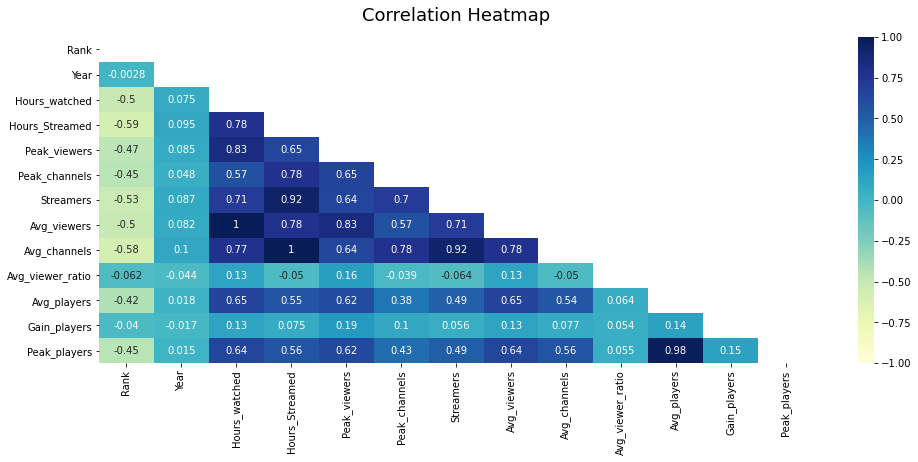

In [52]:
#Creamos una figura
plt.figure(figsize=(16, 6))
# Definimos el triángulo inferior con un correlation plot
mask = np.triu(np.ones_like(df_2020.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_2020.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Vemos que hay poca variación de variables respecto al total de datos

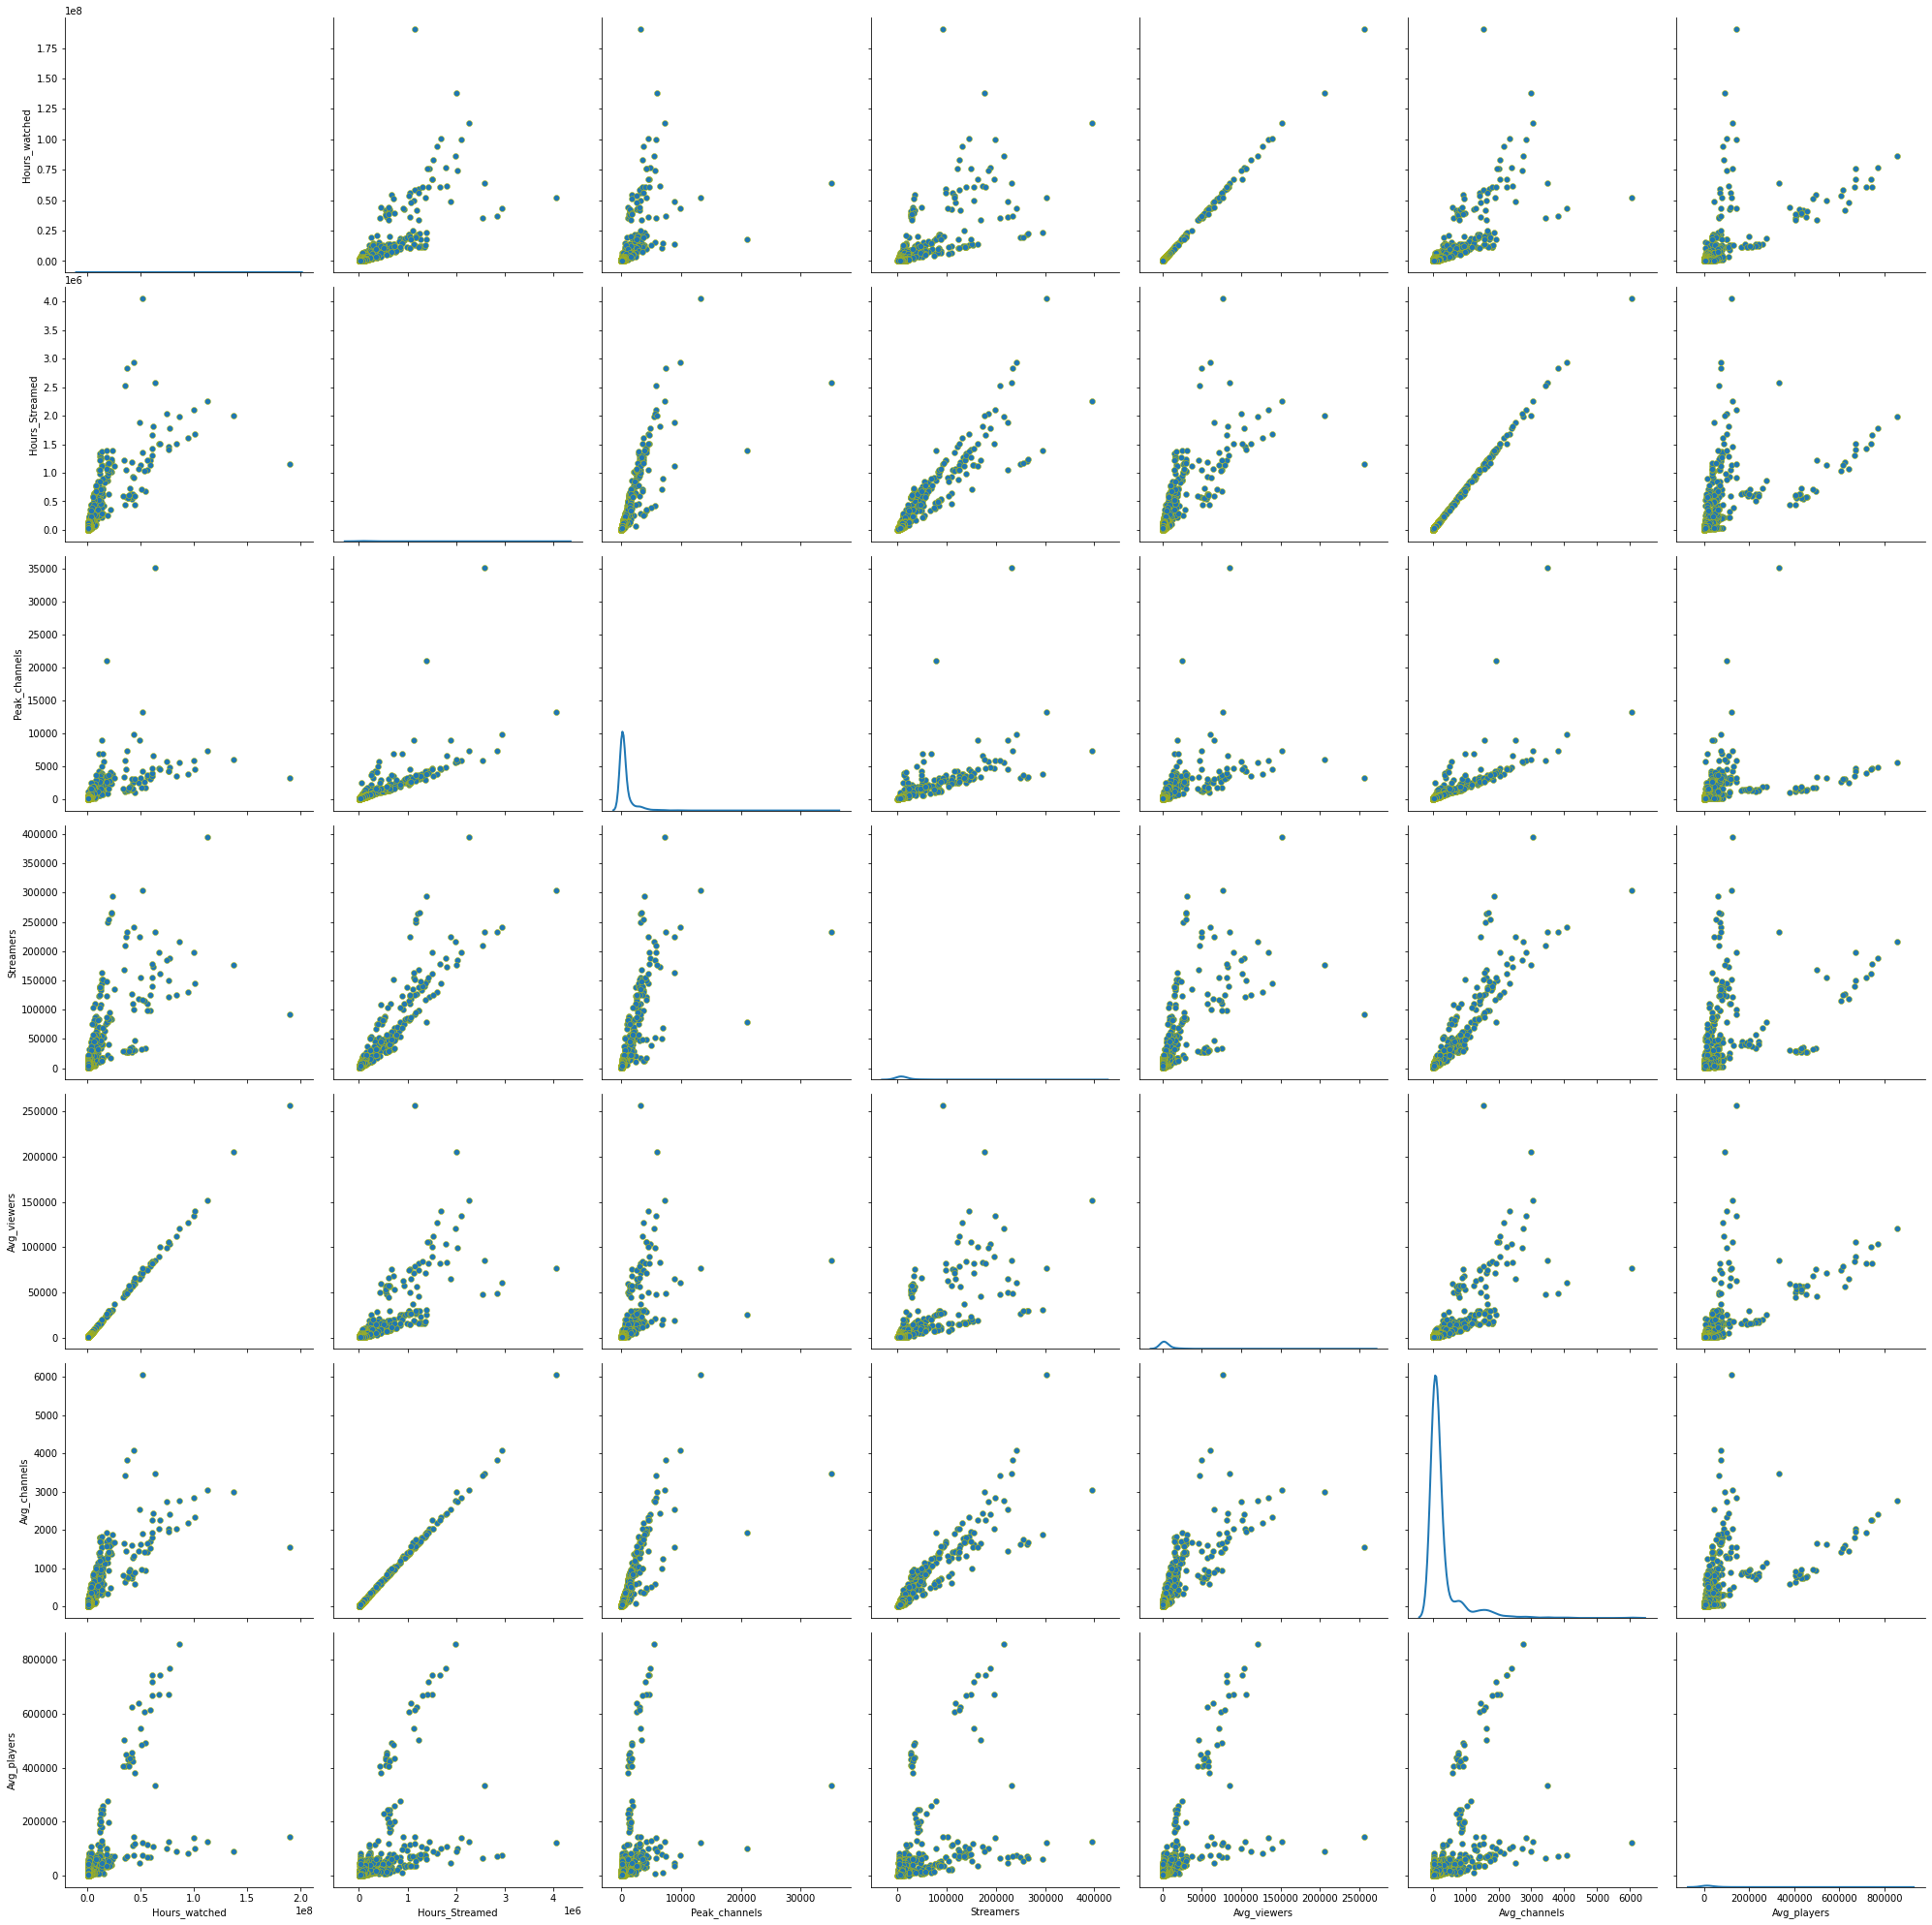

In [53]:
#Creamos un pairgrid que contendrá varios gráficos
grid = sns.PairGrid(df_2020,
             vars = ['Hours_watched', 'Hours_Streamed', 'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_players'],
             size = 4)
grid.map_offdiag(sns.scatterplot, edgecolor="y") #Scatter plot
grid.map_diag(sns.kdeplot, lw=2, legend = False) #kdeplot en la diagonal
plt.show();

Como hemos comentado más arriba nos vamos a centar en la relación de el número de visualizadores y el número de jugadores

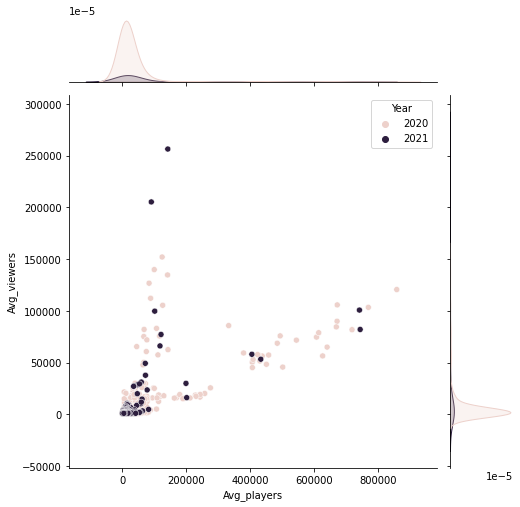

In [54]:
sns.jointplot(data=df_2020, x="Avg_players", y="Avg_viewers", hue="Year", height= 7, cmap="YlGnBu");

Relaciones que podemos ver en la visualización de los datos desde 2020:
* Puntos oscuros pertenecientes a 2021: Como hemos comentado antes se distribuyen por más verticalmente, por lo que indica que hay más usuarios viendo jugar que jugando actualmente. hay que tener en cuenta que al año actual le faltan meses de datos por completar por lo que habrá que estar pendiente de por donde se van completando.
* Resto de puntos 2016-2020: A parte del conglomerado en los ejes, los puntos se distribuyen más diagonalmente, lo que indica que hay un equilibrio entre visualizadores de contenido y jugadores de esos mismos juegos

In [55]:
# Test train split for supervised training
X_var_2020 = df_2020['Avg_viewers'].values.reshape(-1,1)
y_var_2020 = df_2020['Avg_players'].values

X_train_2020, X_test_2020, y_train_2020, y_test_2020 = train_test_split(X_var_2020, y_var_2020, test_size = 0.2, random_state = 0)

In [56]:
def evaluate_2020(X_test_2020, y_test_2020, y_hat_2020):
    plt.scatter(X_test_2020, y_test_2020, color='blue', alpha=.7)
    plt.scatter(X_test_2020, y_hat_2020, color='orange', alpha=.8)

    mse = mean_squared_error(y_test_2020, y_hat_2020)
    rmsee = sqrt(mean_squared_error(y_test_2020,y_hat_2020)) #calculate rmse
    mae = mean_absolute_error(y_test_2020, y_hat_2020)
    mape = np.mean(np.abs(y_test_2020 - y_hat_2020) / y_test_2020)
    ev = explained_variance_score(y_test_2020, y_hat_2020)
    r2score = r2(y_test_2020, y_hat_2020)

    return print( " El MSE es: {}\n".format(mse), "El MAE es: {}\n".format(mae), "El Mape es: {}\n".format(mape), "El EV es: {}\n".format(ev), "El R2 score es: {}\n".format(r2score), "El RMSE score es: {}\n".format(rmsee))

# Lo evaluaremos con evaluate(X_test, y_test, y_hat)

In [57]:
# MODELING

# 1. OLS

ols = LinearRegression()
ols.fit(X_train_2020, y_train_2020)
ols_yhat_2020 = ols.predict(X_test_2020)

# 2. Bayesian

bayesian = BayesianRidge()
bayesian.fit(X_train_2020, y_train_2020)
bayesian_yhat_2020 = bayesian.predict(X_test_2020)

# 3. ElasticNet

en = ElasticNet(alpha = 0.01)
en.fit(X_train_2020, y_train_2020)
en_yhat_2020 = en.predict(X_test_2020)

# 4. KNNRegressor k=3

knn3 = KNeighborsRegressor(3)
knn3.fit(X_train_2020, y_train_2020)
knn3_yhat_2020 = knn3.predict(X_test_2020)

# 5. KNNRegressor k=7

knn7 = KNeighborsRegressor(7)
knn7.fit(X_train_2020, y_train_2020)
knn7_yhat_2020 = knn7.predict(X_test_2020)

# 6. DecisionTreeregressor

tree = DecisionTreeRegressor()
tree.fit(X_train_2020, y_train_2020)
tree_yhat_2020 = tree.predict(X_test_2020)

 El MSE es: 7179993361.642689
 El MAE es: 30655.228904933974
 El Mape es: 4.001780077971781
 El EV es: -0.019766191675435252
 El R2 score es: -0.022911610427162277
 El RMSE score es: 84734.84148591233



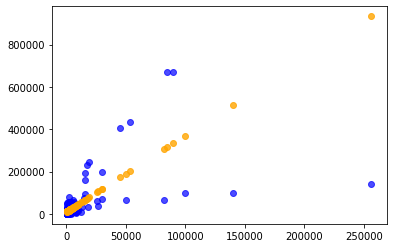

In [58]:
evaluate_2020(X_test_2020, y_test_2020, ols_yhat_2020)

 El MSE es: 7169590383.743407
 El MAE es: 30655.211308866183
 El Mape es: 4.010830494699364
 El EV es: -0.018284605802156406
 El R2 score es: -0.021429530104770667
 El RMSE score es: 84673.4337542975



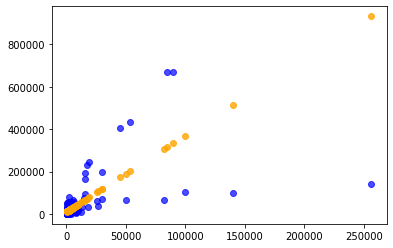

In [59]:
evaluate_2020(X_test_2020, y_test_2020, bayesian_yhat_2020)

 El MSE es: 7179993361.506522
 El MAE es: 30655.22890493375
 El Mape es: 4.001780078090093
 El EV es: -0.01976619165604232
 El R2 score es: -0.022911610407762906
 El RMSE score es: 84734.84148510885



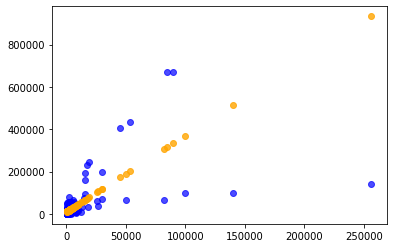

In [60]:
evaluate_2020(X_test_2020, y_test_2020, en_yhat_2020)

 El MSE es: 3822049605.61097
 El MAE es: 24285.99298157454
 El Mape es: 3.020342262187898
 El EV es: 0.4555155758668028
 El R2 score es: 0.4554843270337582
 El RMSE score es: 61822.72725795078



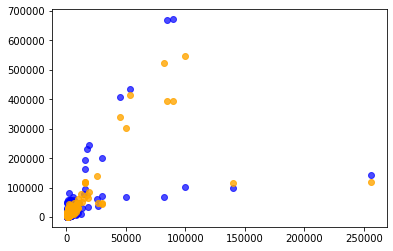

In [61]:
evaluate_2020(X_test_2020, y_test_2020, knn3_yhat_2020)

 El MSE es: 3009688992.914701
 El MAE es: 24020.029124192388
 El Mape es: 3.0551364054917842
 El EV es: 0.5715057076211338
 El R2 score es: 0.5712188494387511
 El RMSE score es: 54860.63245091785



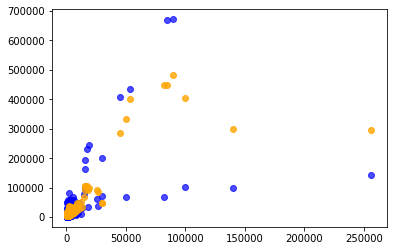

In [62]:
evaluate_2020(X_test_2020, y_test_2020, knn7_yhat_2020)

 El MSE es: 7258137163.298413
 El MAE es: 30482.659003350083
 El Mape es: 3.5617609432169384
 El EV es: -0.03370013428142005
 El R2 score es: -0.03404451793423413
 El RMSE score es: 85194.70149779512



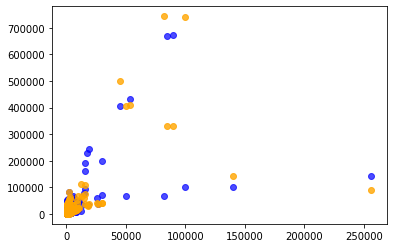

In [63]:
evaluate_2020(X_test_2020, y_test_2020, tree_yhat_2020)

Comparando los datos de los modelos nos quedaríamos con el modelo KNeighbours con k=7 vecinos ya que es el que menos error nos da. Como es el valor superior y puede tender a infinito vamos a calcular cuá es el mejor valor de kvecinos para este modelo

Vamos a calcular cuál serían los kvecinos que tengan el menor RMSE

In [64]:
value_rmse_2020 = [] #Guardar los valores de error de cada kvecino
for X in range(0, 60, 2):
    X = X+1
    model_2020 = KNeighborsRegressor(n_neighbors = X)
    model_2020.fit(X_train_2020, y_train_2020)  #Model fit
    y_hat_2020 = model_2020.predict(X_test_2020) #make prediction on test set
    error_rmse_2020 = sqrt(mean_squared_error(y_test_2020,y_hat_2020)) #calculate rmse
    value_rmse_2020.append(error_rmse_2020) #store rmse values
    print('El RMSE para unos vecinos de k=' ,X, 'es:',error_rmse_2020)

El RMSE para unos vecinos de k= 1 es: 85282.21265776588
El RMSE para unos vecinos de k= 3 es: 61822.72725795078
El RMSE para unos vecinos de k= 5 es: 56016.20742273213
El RMSE para unos vecinos de k= 7 es: 54860.63245091785
El RMSE para unos vecinos de k= 9 es: 60130.39767141666
El RMSE para unos vecinos de k= 11 es: 62175.92945801976
El RMSE para unos vecinos de k= 13 es: 62534.71592918341
El RMSE para unos vecinos de k= 15 es: 60617.299761946604
El RMSE para unos vecinos de k= 17 es: 59744.340967139164
El RMSE para unos vecinos de k= 19 es: 59798.41281172074
El RMSE para unos vecinos de k= 21 es: 58194.441218623244
El RMSE para unos vecinos de k= 23 es: 59751.992999492075
El RMSE para unos vecinos de k= 25 es: 57529.93868592961
El RMSE para unos vecinos de k= 27 es: 57450.92793160513
El RMSE para unos vecinos de k= 29 es: 58095.964293186866
El RMSE para unos vecinos de k= 31 es: 57711.966781232484
El RMSE para unos vecinos de k= 33 es: 57561.330228783365
El RMSE para unos vecinos de 

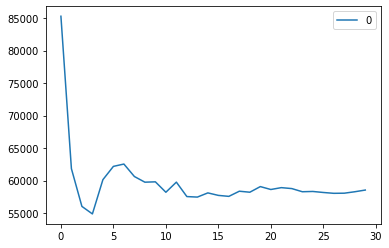

In [65]:
#Dibujamos los valores de RMSE en función de los k vecinos
curve_rmse_2020 = pd.DataFrame(value_rmse_2020) #elbow curve 
curve_rmse_2020.plot();

Vemos como la curva cae en los valores del 0 al 10, por lo que vamos a insertar esos valores mínimos en GridSearchCV para que nos determine cuál es el mejor valor

In [66]:
parameters_2020 = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knnreg_2020 = KNeighborsRegressor()

model_2020_1 = GridSearchCV(knnreg_2020, parameters_2020, cv=5) #Determines the cross-validation splitting strategy
model_2020_1.fit(X_train_2020, y_train_2020)
model_2020_1.best_params_

{'n_neighbors': 6}

 El MSE es: 3017939020.0452223
 El MAE es: 23722.15546063652
 El Mape es: 2.9694385937737984
 El EV es: 0.5705167268792244
 El R2 score es: 0.5700434934024583
 El RMSE score es: 54935.77177072533



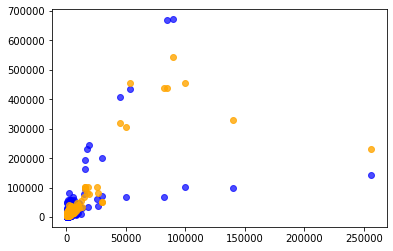

In [67]:
# KNNRegressor k=6

knn5_2020 = KNeighborsRegressor(6)
knn5_2020.fit(X_train_2020, y_train_2020)
knn5_yhat_2020 = knn5_2020.predict(X_test_2020)

evaluate_2020(X_test_2020, y_test_2020, knn5_yhat_2020)

Para los datos a partir de 2020 hay que tener en cuenta que son escasos en comparación con el modelo anterior. En este caso el mejor modelo para predecir el número de jugadores en función del número de espectadores es el KNNregresor con un parámetro k=6.

###  Exportamos nuestro modelo con Joblib

Para poder usar nuestro modelo en un front-end vamos a tener que exportarlo en formato pkl

In [68]:
model_file = open("Models/knn5_regression_covid.pkl","wb")
joblib.dump(knn5_2020, model_file)
model_file.close()

###  Exportamos nuestro nuevo dataset con datos a partir de 2020 mergeado

Para poder usar con los datos completos en un front-end

In [36]:
#Exportamos los datos totales de Steam y Twitch
df_2020.to_csv('2020 data stream and games.csv', encoding='utf-8', index=False, header=True)

# Conclusiones

Tras trabajar en 2 notebooks distintas con dos fuentes de datos distintas, hemos conseguido unir datos de dos plataformas del mismo sector y que tengan sentido. Se ha podido demostrar la correlación entre visualizadores de la plataforma de Twitch y su repercusión en el número de jugadores en Steam.

Ha quedado demostrado que el impacto del covid-19 en este sector ha sido importante pero de una forma positiva. Los confinamientos y por lo tanto la necesidad de entretenimiento en nuestras casas ha hecho que estas dos empresas se beneficien en mayor y menor medida.

A raíz de este impacto tan fuerte por factores externos al sector, se ha decidido desarrollar 2 modelos de regresión para poder predecir en diferentes ámbitos el número de jugadores que va a tener un determinad videjuego en función del número de visualizadores en Steam. Unos ejemplos de estas aplicaciones serían:
* Promoción de un nuevo videojuego: Cuando una empresa quiere lanzar un videojuego no promociona a traves de diferentes canales. Como ha quedado demostrado Twitch engloba a un perfil de usuarios muy específico y que está en pleno crecimiento con millones de horas visualizadas por mes. Saber una cifra aproximada del retorno de la inversión (ROI) puede determinar las colaboraciones con Streamers de Twitch. 
* Promoción de eventos dentro de videojuegos: Existe una tendencia reciente de crear eventos dentro de videojuegos con fines específicos. Fornite los popularizó con conciertos dentro de su juego y se ha extendido en otros formatos.

#### Proximos pasos

Habría que seguir recopilando datos porque tenemos varios factores que afectan al proyecto para completarlo:
- Falta transparencia por parte de las empresas del sector. Se entiende que, el sector de los videojuegos y el streaming, es un sector muy competido y con un amplio crecimiento como hemos visto en los datos, pero la facilitación de más datos para explotar mejoraría la búsqueda de nuevas oportunidades y nichos en el mercado.
- Impacto de factores externos: La aparición del covid-19 ha cambiado las costumbres de los consumidores. La tendencia es muy alcista desde febrero de 2020 pero habrá que esperar a tener más datos durante varios años para ver si se mantiene.